In [72]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [73]:
# defining the key parameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [74]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [75]:
x = Input(shape=(original_dim), name="input")  #Input to our encoder
h = Dense(intermediate_dim, activation='relu', name = "encoding")(x) #Intermediate Layer
z_mean = Dense(latent_dim, name = "mean")(h) #Defines the mean of the latent space
z_log_var = Dense(latent_dim, name = "log-variance")(h) #Defines the log variance of the latent space
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var]) #The output shape is not necessary with the TensorFlow backend
encoder = Model(x,  [z_mean, z_log_var, z], name="encoder") #Defines the encoder as a Keras model 
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 encoding (Dense)            (None, 256)                  200960    ['input[0][0]']               
                                                                                                  
 mean (Dense)                (None, 2)                    514       ['encoding[0][0]']            
                                                                                                  
 log-variance (Dense)        (None, 2)                    514       ['encoding[0][0]']            
                                                                                            

In [76]:
input_decoder = Input(shape=(latent_dim), name = "decoder_input") #Input to the decoder
decoder_h = Dense(intermediate_dim, activation='relu', name= "decoder_h")(input_decoder) # Takes the latent space to the intermediate dimension
x_decoded = Dense(original_dim, activation='sigmoid', name= "flat_decoded")(decoder_h) # Gets the mean from the original dimension
decoder = Model(input_decoder, x_decoded, name = "decoder") 


In [77]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [78]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (100, 2)]                          
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
vae.compile(optimizer='adam', loss='binary_crossentropy')

In [80]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [84]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=1)

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1951 - val_loss: 0.1946
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1934 - val_loss: 0.1931
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1919 - val_loss: 0.1916
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1906 - val_loss: 0.1906
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1894 - val_loss: 0.1893
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1884 - val_loss: 0.1885
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1874 - val_loss: 0.1876
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1866 - val_loss: 0.1870
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1857 - val_loss: 0.1863
Epoch 10/50
600/600 [==============================] - 2s 3ms/step - loss: 0.1850 - val_loss: 0.1857

100/100 [==============================] - 0s 557us/step


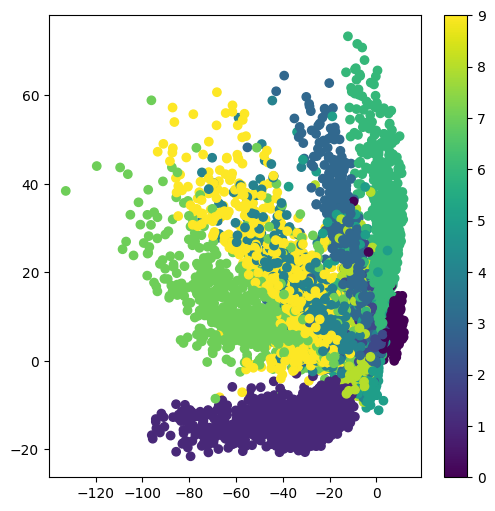

In [85]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 8ms/step


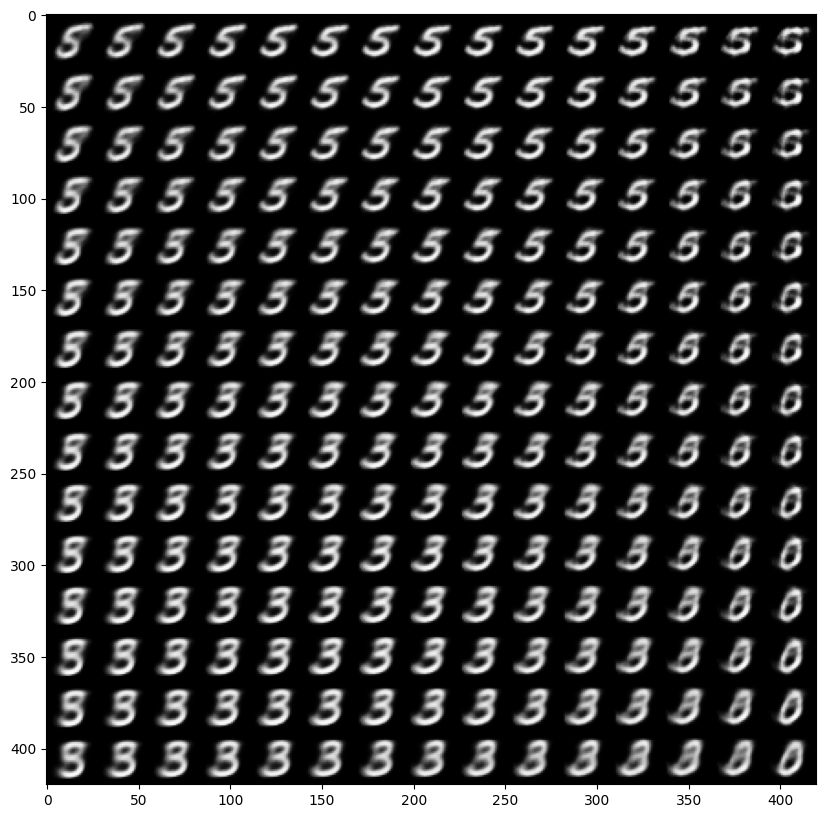

In [86]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()